## 1. Import Libraries

We need PyTorch for training neural networks and the Segmentation Models library which provides pretrained U-Net architectures.

**Note:** If you get an import error for `SENTINEL_DIR`, restart the kernel (Kernel → Restart Kernel) to clear the cached imports.

In [1]:
import importlib
import sys
if 'src.config' in sys.modules:
    importlib.reload(sys.modules['src.config'])

In [2]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import wandb

root = Path().resolve().parents[0]
sys.path.append(str(root))

from src.config import SENTINEL_DIR, MASK_DIR
from src.data.sentinel_habloss_dataset import SentinelHablossPatchDataset

/Users/cecilia/Desktop/NTNU/Fordypningsprosjekt/Land-Take-Prediction-Project-NINA-/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Setup Device

Check if we have a GPU available. Training on GPU is apparently much faster than CPU.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 3. Define Train/Val/Test Splits

We have 20 REFIDs with both Sentinel images and ground truth masks. We split them:
- **Training set:** 14 REFIDs (70%) - used to train the model
- **Validation set:** 3 REFIDs (15%) - used to tune hyperparameters and monitor training
- **Test set:** 3 REFIDs (15%) - held out for final evaluation

This ensures the model is tested on completely unseen geographic locations.

In [4]:
# All available REFIDs (now with all 20 pairs having both Sentinel images and masks)
all_ref_ids = [
    "a-0-47134313698222_52-09242527089813",
    "a-0-54402407469629_44-04188024421709",
    "a-0-77133618972711_46-45684360844514",
    "a-1-18139547412802_52-25772329329998",
    "a-1-34144867248374_47-02619422462487",
    "a-1-58467935875357_47-05443474717619",
    "a-18-03071366712101_65-66474845645646",
    "a-2-17104025185075_39-66195264271502",
    "a-2-22932139889146_56-95862408026678",
    "a-2-52025858362194_53-72050616794933",
    "a-2-59185730215767_53-11198720241597",
    "a-3-82567804883019_40-09254102374404",
    "a-3-99571454125387_43-28658119907893",
    "a-4-04049538502545_47-97554982426387",
    "a-6-53797725923809_53-84911799426187",
    "a-8-19813509533539_41-63652669165629",
    "a0-07602270798631_51-64536656448906",
    "a0-17451673427384_52-65135035939731",
    "a0-25914391012373_52-41062988926688",
    "a0-6941135513559_49-61269109310156"
]

# Split: 70% train (14), 15% val (3), 15% test (3)
train_ref_ids = all_ref_ids[:14]
val_ref_ids = all_ref_ids[14:17]
test_ref_ids = all_ref_ids[17:]# Split: 70% train (14), 15% val (3), 15% test (3)
train_ref_ids = all_ref_ids[:14]
val_ref_ids = all_ref_ids[14:17]
test_ref_ids = all_ref_ids[17:]

print(f"Train REFIDs: {len(train_ref_ids)}")
print(f"Val REFIDs: {len(val_ref_ids)}")
print(f"Test REFIDs: {len(test_ref_ids)}")

Train REFIDs: 14
Val REFIDs: 3
Test REFIDs: 3


In [5]:
# Reload the dataset module to get the latest changes
import importlib
import src.data.sentinel_habloss_dataset
importlib.reload(src.data.sentinel_habloss_dataset)
from src.data.sentinel_habloss_dataset import SentinelHablossPatchDataset

## 4. Create Datasets and Data Loaders

Now we create separate datasets for training and validation using the REFID splits.

**Training dataset:**
- Uses 14 REFIDs
- 20 patches per image
- Data augmentation enabled (random flips)

**Validation dataset:**
- Uses 3 REFIDs (completely different locations)
- 10 patches per image
- No augmentation (for consistent evaluation)

In [6]:
mean = None
std = None

train_ds = SentinelHablossPatchDataset(
    SENTINEL_DIR, MASK_DIR, 
    patch_size=128,
    patches_per_image=20, 
    mean=mean, 
    std=std, 
    augment=True,
    ref_ids=train_ref_ids
)

val_ds = SentinelHablossPatchDataset(
    SENTINEL_DIR, MASK_DIR, 
    patch_size=128,
    patches_per_image=10, 
    mean=mean, 
    std=std, 
    augment=False,
    ref_ids=val_ref_ids
)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

print(f"Training patches: {len(train_ds)} (from {len(train_ref_ids)} REFIDs)")
print(f"Validation patches: {len(val_ds)} (from {len(val_ref_ids)} REFIDs)")
print(f"Number of input channels: {train_ds.num_bands}")

Training patches: 280 (from 14 REFIDs)
Validation patches: 30 (from 3 REFIDs)
Number of input channels: 126


## 5. Build the U-Net Model

The model now takes multitemporal Sentinel data as input. The number of input channels will be determined automatically based on the data (e.g., if we have 2 timesteps with 7 bands each = 14 channels).

In [7]:
num_input_channels = train_ds.num_bands

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=126,
    classes=2
).to(device)

print(f"Model created with {num_input_channels} input channels and moved to {device}")

Model created with 126 input channels and moved to cpu


## 6. Setup Loss Function and Optimizer

**Loss function (CrossEntropyLoss):** Measures how wrong the model's predictions are. Lower is better.

**Optimizer (Adam):** Updates the model weights to reduce the loss. Learning rate controls how big the update steps are.

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## 7. Define Training Function

This function processes one epoch (one pass through all the data). It can run in training mode or evaluation mode:

- **Training mode:** The model learns from the data and updates its weights
- **Evaluation mode:** The model makes predictions but doesn't learn (for validation)

The function returns the average loss and accuracy for the epoch.

In [9]:
def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_correct = 0
    total_pixels = 0

    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        with torch.set_grad_enabled(train):
            logits = model(imgs)
            loss = loss_fn(logits, masks)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * imgs.size(0)

        preds = logits.argmax(dim=1)
        total_correct += (preds == masks).sum().item()
        total_pixels  += masks.numel()

    avg_loss = total_loss / len(loader.dataset)
    acc = 100.0 * total_correct / total_pixels
    return avg_loss, acc

## 7.5. Initialize Weights & Biases (WandB)

WandB is a tool for tracking experiments, visualizing metrics, and comparing model runs. We'll use it to:
- Log training/validation loss and accuracy
- Track hyperparameters
- Visualize example predictions
- Monitor model gradients

In [14]:
wandb.init(
    project="smp_unet",
    entity="nina_prosjektoppgave",
    config={
        "model": "Unet",
        "encoder": "resnet34",
        "encoder_weights": "imagenet",
        "in_channels": 126,
        "classes": 2,
        "learning_rate": 1e-3,
        "batch_size": 8,
        "patch_size": 128,
        "epochs": 10,
        "train_patches_per_image": 20,
        "val_patches_per_image": 10,
        "train_ref_ids": len(train_ref_ids),
        "val_ref_ids": len(val_ref_ids),
        "augmentation": True,
    },
)

# Watch model gradients and parameters
wandb.watch(model, log="all", log_freq=100)

## 8. Train the Model

Run the training loop for 10 epochs. Each epoch:
1. Trains on all training data
2. Validates on all validation data
3. Prints the results

In [15]:
def log_examples(images, masks, preds, step, phase="train"):
    """
    Log example predictions to WandB.
    
    Args:
        images: (B, C, H, W) input images
        masks: (B, H, W) ground truth masks
        preds: (B, 2, H, W) model logits
        step: current step/epoch
        phase: "train" or "val"
    """
    # Convert logits to predictions (get class with highest probability)
    preds_class = preds.argmax(dim=1)  # (B, H, W)
    
    # Take first 3 bands as RGB visualization (normalize to 0-1 range)
    rgb_imgs = images[:, :3, :, :].clone()
    for i in range(3):
        min_val = rgb_imgs[:, i, :, :].min()
        max_val = rgb_imgs[:, i, :, :].max()
        if max_val > min_val:
            rgb_imgs[:, i, :, :] = (rgb_imgs[:, i, :, :] - min_val) / (max_val - min_val)
    
    wandb_images = []
    for i in range(min(4, images.size(0))):
        wandb_images.append(
            wandb.Image(
                rgb_imgs[i].cpu(),
                masks={
                    "ground_truth": {"mask_data": masks[i].cpu().numpy(), "class_labels": {0: "background", 1: "land-take"}},
                    "prediction": {"mask_data": preds_class[i].cpu().numpy(), "class_labels": {0: "background", 1: "land-take"}},
                },
            )
        )
    
    wandb.log({f"{phase}_examples": wandb_images}, step=step)

In [ ]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(10):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc = run_epoch(val_loader, train=False)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Log metrics to WandB
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })
    
    # Log example predictions every 2 epochs
    if (epoch + 1) % 2 == 0:
        model.eval()
        with torch.no_grad():
            # Get a batch from validation set
            val_imgs, val_masks = next(iter(val_loader))
            val_imgs = val_imgs.to(device)
            val_preds = model(val_imgs)
            log_examples(val_imgs, val_masks, val_preds, step=epoch + 1, phase="val")
    
    print(f"Epoch {epoch+1}: "
          f"Train loss {train_loss:.3f}, acc {train_acc:.1f}% | "
          f"Val loss {val_loss:.3f}, acc {val_acc:.1f}%")

# Finish WandB run after all epochs
wandb.finish()

## 9. Visualize Training Progress

Plot the loss and accuracy curves to see how the model improved over time.

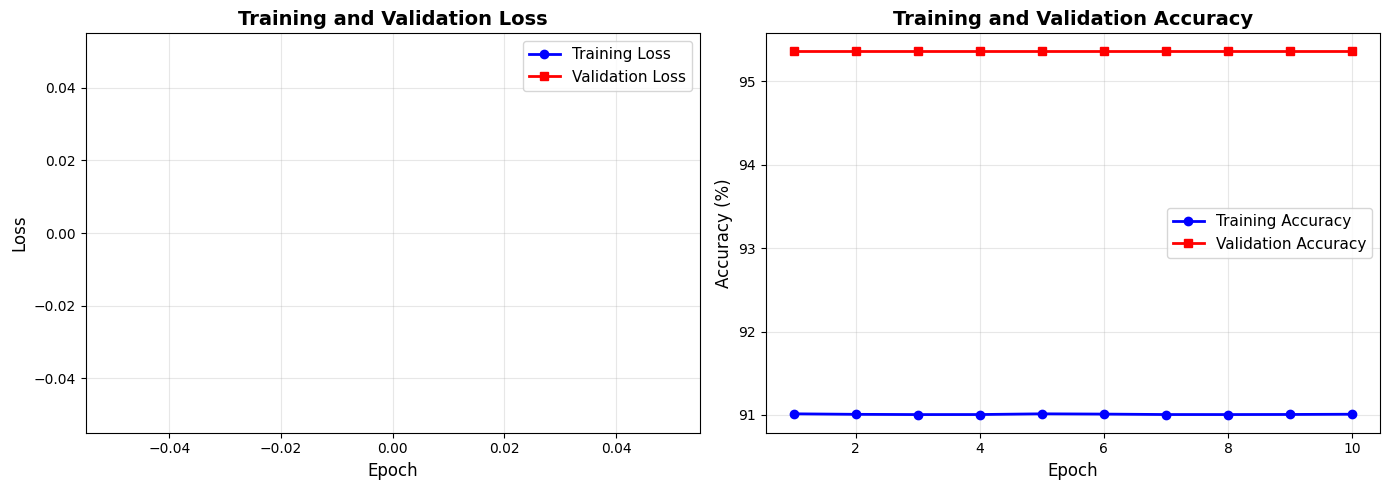


Final Results:
Training   - Loss: nan, Accuracy: 91.0%
Validation - Loss: nan, Accuracy: 95.4%


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(train_losses) + 1)

ax1.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
ax1.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, train_accs, 'b-o', label='Training Accuracy', linewidth=2, markersize=6)
ax2.plot(epochs, val_accs, 'r-s', label='Validation Accuracy', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"Training   - Loss: {train_losses[-1]:.3f}, Accuracy: {train_accs[-1]:.1f}%")
print(f"Validation - Loss: {val_losses[-1]:.3f}, Accuracy: {val_accs[-1]:.1f}%")